In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows, preprocess

from decode_tueg import (
    get_preprocessors,
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_chronological_vs_predicted_age, plot_age_gap_hist,
    plot_thresh_to_acc, plot_joint_scatter, plot_learning, save_fig,
    load_exp, predict_ds, plot_heatmaps, plot_heatmap
)

In [3]:
base_dir = '/home/jovyan/new_full_runs/'
# base_dir = '/home/jovyan/outdated_runs/'
# base_dir = '/home/jovyan/full_runs/'
exps = {
    'huber': {
         0: '220824144055632350',
         1: '220824191628058941',
         2: '220824144128724203',
         3: '220824144139015381',
         4: '220824144141880751',
    },
    'mse': {
        0: '220825094141505678',
        1: '220825094133879370',
        2: '220825094140973211',
        3: '220825094139201071',
        4: '220825141741077814',
        
    },
    'mae': {
        0: '220826151546978486',
         1: '220826104417444602',
         2: '220826104408477306',
         3: '220826104426911900',
         4: '220826104430495864',
    },
    'nll': {
        0: '220831200810717294',
    },
    # old results
#     'huber': {
#         0: '220824144254199487',
#     },
#     'nll': {
#         0: '220725141944002603'
#     },
}
# seeds = []  #  TODO: run multiple seeds
model = 'train_end'  # 'train_end', 'valid_best'
n_jobs = 6

In [4]:
only_valid = True
subsets = ['mixed']#, 'mixed', 'abnormal']
mem_efficient = True
exp_style = 'huber'

In [5]:
# hardcoded to enable order in code below
window_size_samples = 6000
window_stride_samples = 496

In [ ]:
for longitudinal in ['transition', 'non_pathological', 'pathological']:
    print('longitudinal', longitudinal)
#     out_dir = os.path.join(base_dir, exp)
    with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
        ds = pickle.load(f)
    
#     ds = ds.split(list(range(10)))['0']
    print(f'n={len(ds.datasets)}')

    print('preprocess')
    preprocessors = get_preprocessors(59, tmax=None)
    ds = preprocess(ds, preprocessors=preprocessors, n_jobs=n_jobs)
    
    print('create windows')
    ds = create_fixed_length_windows(
        ds,
        window_size_samples=window_size_samples,
        window_stride_samples=window_stride_samples,
        n_jobs=min(n_jobs, 4),
        preload=False,
        mapping=None,
        drop_last_window=False,
        drop_bad_windows=True,
        reject=None,
        flat=None,
    )
    
    dfs = []
    for exp_i, exp in exps[exp_style].items():
        print('exp', exp)
        clf, data_scaler, target_scaler, config = load_exp(base_dir, exp, model)
        if isinstance(data_scaler, list):
            data_scaler = data_scaler[0]  # TODO: fix this
        
        print('predicting')
        preds, targets = predict_ds(
            clf,
            ds, 
            'age',
            target_scaler,
            data_scaler,
            n_jobs,
            mem_efficient=mem_efficient,
            trialwise=True,
            average_time_axis=True,
        )
        if config.target_name in ['age']:
            score = mean_absolute_error(targets, preds)
        else:
            score = balanced_accuracy_score(targets, preds)

        # TODO: add subject
        df = pd.DataFrame({
            'y_pred': preds.ravel(),
            'y_true': targets.ravel(),
            'pathological': ds.description['pathological'].to_numpy() == 1,
            'exp': len(ds.description) * [exp],
#             'subset': len(ds.description) * [subset],
            'split': len(ds.description) * [longitudinal],
            'fold': len(ds.description) * [exp_i],
        })
        dfs.append(df)
    dfs = pd.concat(dfs, ignore_index=True)
    dfs.to_csv(f'/home/jovyan/220824_5fcv_{exp_style}_longitudinal_{longitudinal}.csv')

longitudinal transition
n=3357
preprocess
2022-09-07 20:00:13 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting
exp 220824144141880751
predicting
longitudinal non_pathological
n=4068
preprocess
2022-09-07 22:04:23 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting
exp 220824144141880751
predicting
longitudinal pathological
n=18338
preprocess
2022-09-08 00:26:38 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting


In [16]:
subject_wise = False
bin_size = 3
max_age = 100

41.66515731573105

In [ ]:
np.histogram2d()

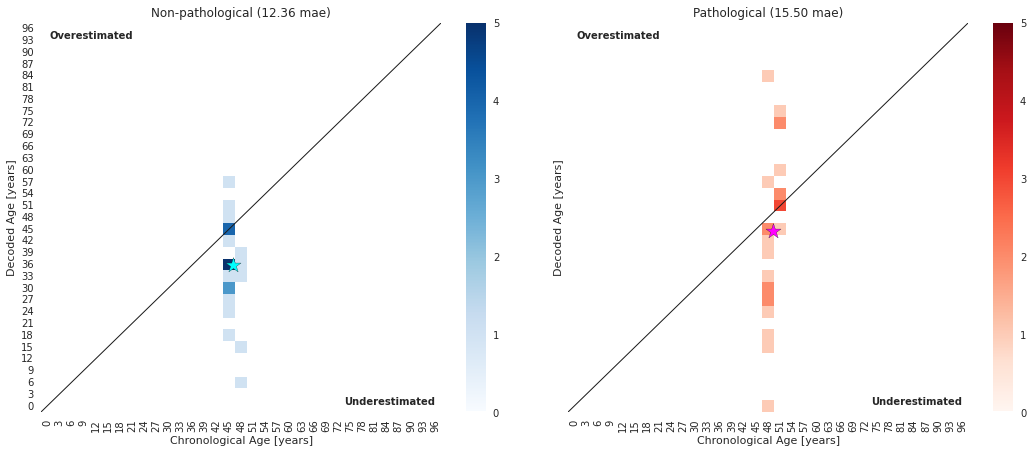

In [55]:
# fdescribe i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
longitudinal = 'transition'
df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
if subject_wise:
    df = df.groupby(['subject', 'pathological'], as_index=False).mean()

ax_arr = plot_heatmaps(df, bin_size, max_age)
#save_fig(ax.get_figure(), out_dir, f'longitudinal-{longitudinal}_chronological_vs_predicted_age')

hi


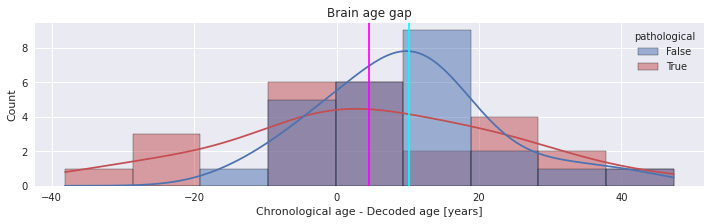

In [26]:
# for i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
if subject_wise:
    df = df.groupby(['subject', 'pathological'], as_index=False).mean()

ax = plot_age_gap_hist(df)
#save_fig(ax.get_figure(), out_dir, f'longitudinal-{longitudinal}_chronological_vs_predicted_age')